Epoch 1/200
64/64 - 3s - loss: 0.1328 - val_loss: 0.0157 - 3s/epoch - 40ms/step
Epoch 2/200
64/64 - 0s - loss: 0.0536 - val_loss: 0.0277 - 232ms/epoch - 4ms/step
Epoch 3/200
64/64 - 0s - loss: 0.0428 - val_loss: 0.0227 - 259ms/epoch - 4ms/step
Epoch 4/200
64/64 - 0s - loss: 0.0394 - val_loss: 0.0185 - 269ms/epoch - 4ms/step
Epoch 5/200
64/64 - 0s - loss: 0.0355 - val_loss: 0.0173 - 241ms/epoch - 4ms/step
Epoch 6/200
64/64 - 0s - loss: 0.0331 - val_loss: 0.0131 - 239ms/epoch - 4ms/step
Epoch 7/200
64/64 - 0s - loss: 0.0304 - val_loss: 0.0140 - 247ms/epoch - 4ms/step
Epoch 8/200
64/64 - 0s - loss: 0.0298 - val_loss: 0.0141 - 265ms/epoch - 4ms/step
Epoch 9/200
64/64 - 0s - loss: 0.0289 - val_loss: 0.0109 - 244ms/epoch - 4ms/step
Epoch 10/200
64/64 - 0s - loss: 0.0293 - val_loss: 0.0120 - 242ms/epoch - 4ms/step
Epoch 11/200
64/64 - 0s - loss: 0.0290 - val_loss: 0.0115 - 241ms/epoch - 4ms/step
Epoch 12/200
64/64 - 0s - loss: 0.0285 - val_loss: 0.0107 - 272ms/epoch - 4ms/step
Epoch 13/200
64

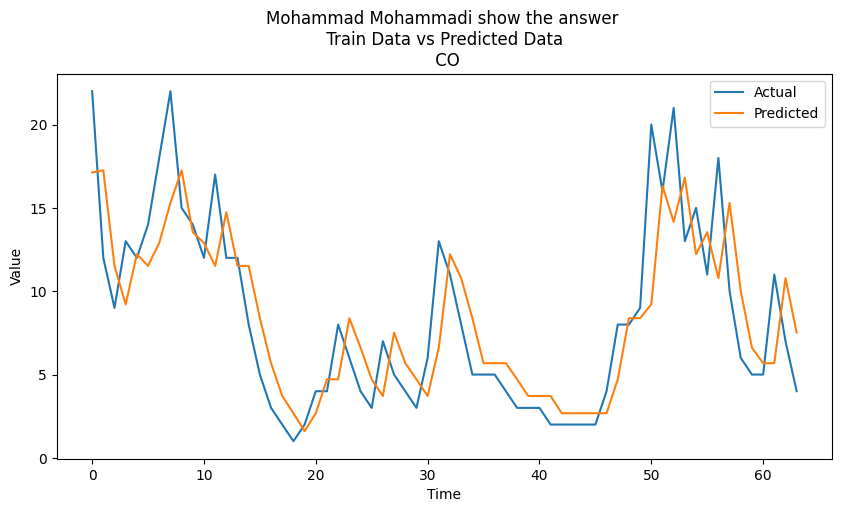

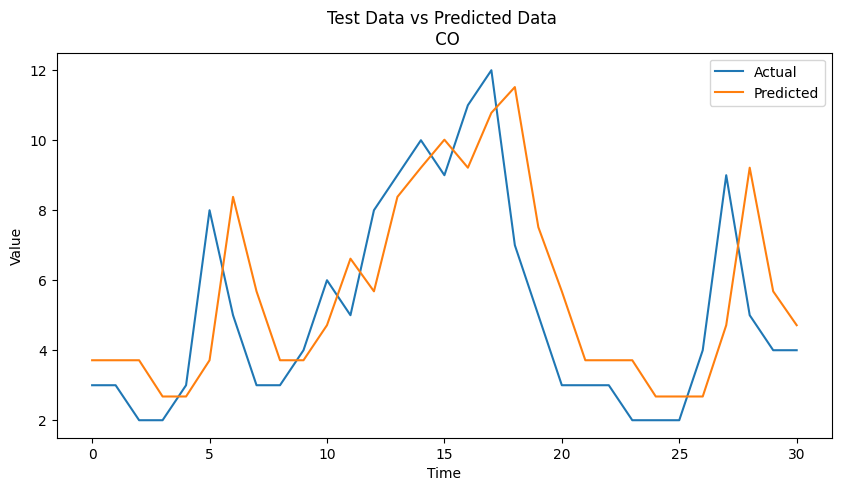

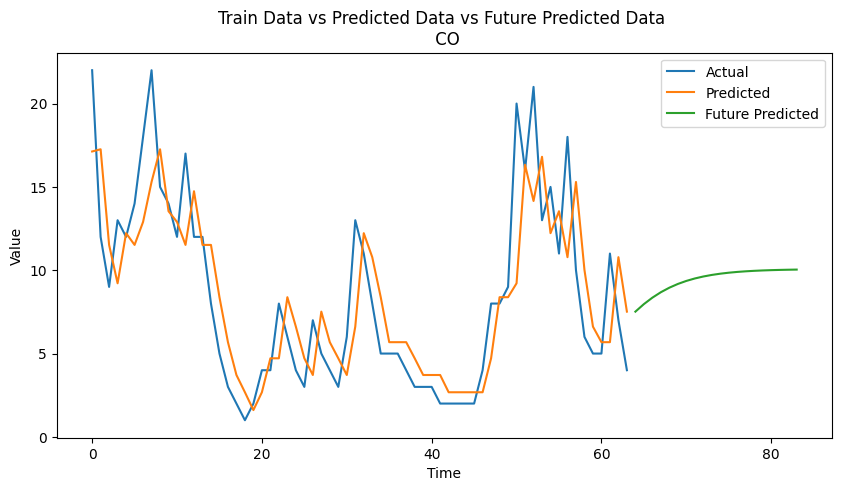

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# بستن تمام پنجره‌های نمودار باز
plt.close('all')

# بارگذاری داده‌ها از فایل CSV
df = pd.read_csv('example1.csv')

# دریافت لیست نام ستون‌ها
df_columns = list(df.columns)

# انتخاب ستون مورد نظر برای نمایش داده‌ها
selected_column = df_columns[8]

# انتخاب 100 داده اول از ستون مورد نظر
data_to_plot = df[selected_column][:99].values.reshape(-1,1)  # تبدیل به آرایه دو بعدی برای مقیاس‌بندی

# مقیاس‌بندی داده‌ها
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_plot)

# تقسیم داده‌ها به دو بخش آموزشی و تست
train_size = int(len(scaled_data) * 0.67)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# تابع برای ایجاد داده‌های آموزشی
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# ایجاد داده‌های آموزشی و تست
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# تغییر شکل ورودی‌ها برای LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# ایجاد و آموزش شبکه LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2, validation_data=(testX, testY))

# پیش‌بینی‌ها
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# تبدیل پیش‌بینی‌ها به مقیاس اصلی
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# تعداد نقاط داده‌ای که می‌خواهیم پیش‌بینی کنیم
num_future_points = 20

# آخرین نقطه داده‌ای از مجموعه داده‌های آموزشی
last_point = trainX[-1]

# لیست برای نگهداری پیش‌بینی‌های آینده
future_predictions = []

# حلقه برای پیش‌بینی نقاط داده‌های آینده
for _ in range(num_future_points):
    # پیش‌بینی با استفاده از آخرین نقطه داده‌ای
    prediction = model.predict(last_point.reshape(1, 1, look_back))

    # اضافه کردن پیش‌بینی به لیست
    future_predictions.append(prediction[0,0])

    # به‌روزرسانی آخرین نقطه داده‌ای با استفاده از پیش‌بینی جدید
    last_point = np.roll(last_point, -1)
    last_point[-1] = prediction

# تبدیل پیش‌بینی‌های آینده به مقیاس اصلی
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# نمایش نمودارها
plt.figure(figsize=(10, 5))
plt.plot(trainY[0], label='Actual')
plt.plot(trainPredict[:,0], label='Predicted')
plt.title('Mohammad Mohammadi show the answer \n Train Data vs Predicted Data \n CO')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(testY[0], label='Actual')
plt.plot(testPredict[:,0], label='Predicted')
plt.title('Test Data vs Predicted Data \n CO')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



# اضافه کردن پیش‌بینی‌های آینده به نمودار
plt.figure(figsize=(10, 5))
plt.plot(range(len(trainY[0])), trainY[0], label='Actual')
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Predicted')
plt.plot(range(len(trainY[0]), len(trainY[0])+num_future_points), future_predictions[:,0], label='Future Predicted')
plt.title('Train Data vs Predicted Data vs Future Predicted Data \n CO')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()




Epoch 1/200
64/64 - 3s - loss: 0.0047 - val_loss: 0.1025 - 3s/epoch - 43ms/step
Epoch 2/200
64/64 - 0s - loss: 0.0032 - val_loss: 0.0877 - 252ms/epoch - 4ms/step
Epoch 3/200
64/64 - 0s - loss: 0.0027 - val_loss: 0.0727 - 259ms/epoch - 4ms/step
Epoch 4/200
64/64 - 0s - loss: 0.0025 - val_loss: 0.0628 - 261ms/epoch - 4ms/step
Epoch 5/200
64/64 - 0s - loss: 0.0019 - val_loss: 0.0466 - 271ms/epoch - 4ms/step
Epoch 6/200
64/64 - 0s - loss: 0.0017 - val_loss: 0.0303 - 275ms/epoch - 4ms/step
Epoch 7/200
64/64 - 0s - loss: 0.0015 - val_loss: 0.0293 - 257ms/epoch - 4ms/step
Epoch 8/200
64/64 - 0s - loss: 0.0012 - val_loss: 0.0210 - 255ms/epoch - 4ms/step
Epoch 9/200
64/64 - 0s - loss: 0.0011 - val_loss: 0.0160 - 258ms/epoch - 4ms/step
Epoch 10/200
64/64 - 0s - loss: 0.0011 - val_loss: 0.0144 - 271ms/epoch - 4ms/step
Epoch 11/200
64/64 - 0s - loss: 0.0011 - val_loss: 0.0113 - 264ms/epoch - 4ms/step
Epoch 12/200
64/64 - 0s - loss: 0.0011 - val_loss: 0.0114 - 272ms/epoch - 4ms/step
Epoch 13/200
64

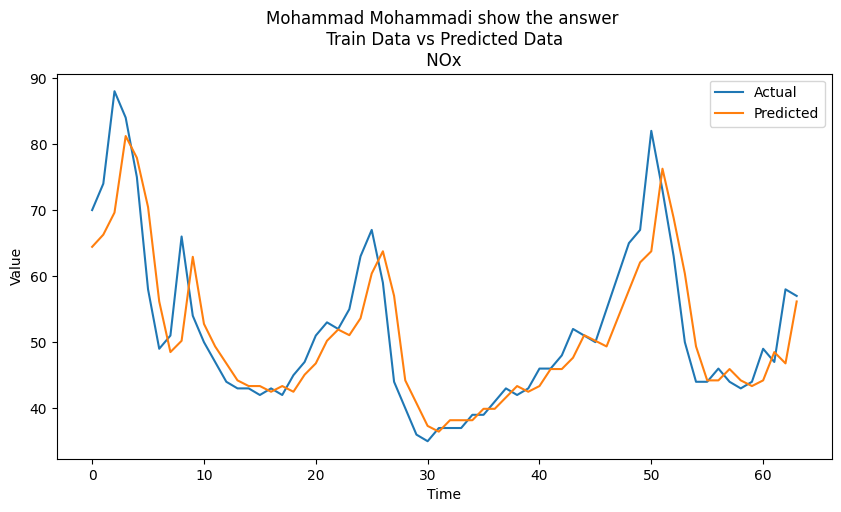

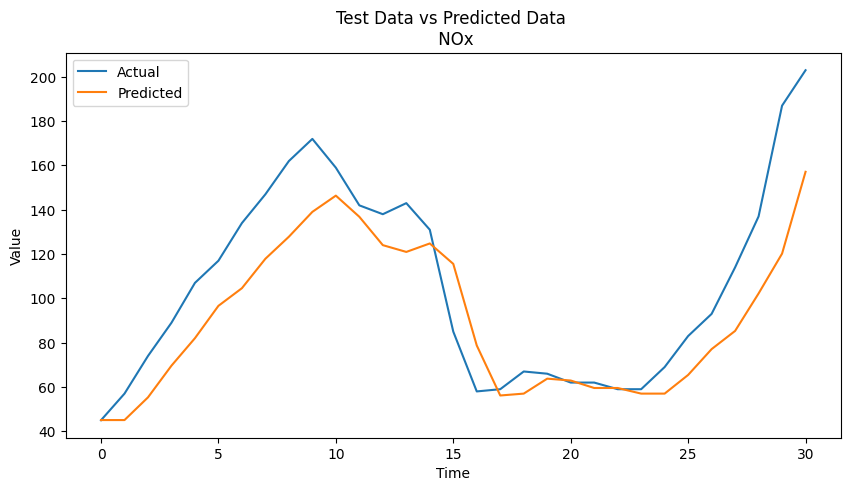

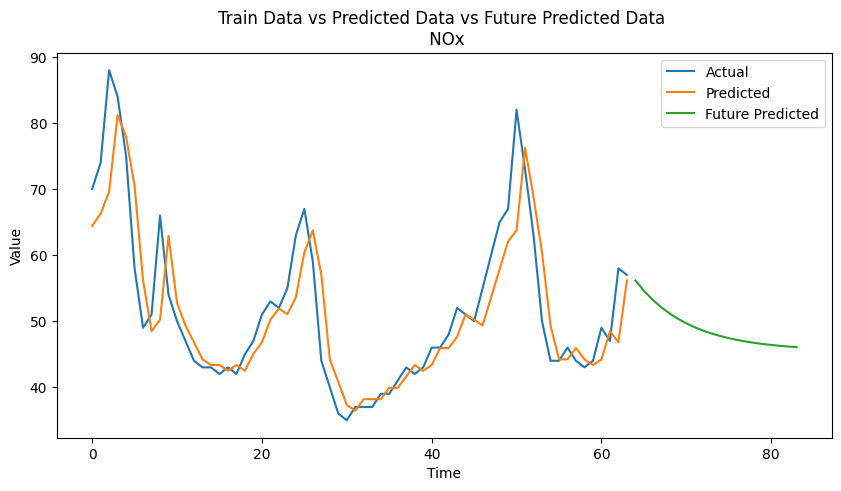

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# بستن تمام پنجره‌های نمودار باز
plt.close('all')

# بارگذاری داده‌ها از فایل CSV
df = pd.read_csv('example1.csv')

# دریافت لیست نام ستون‌ها
df_columns = list(df.columns)

# انتخاب ستون مورد نظر برای نمایش داده‌ها
selected_column = df_columns[5]

# انتخاب 100 داده اول از ستون مورد نظر
data_to_plot = df[selected_column][:99].values.reshape(-1,1)  # تبدیل به آرایه دو بعدی برای مقیاس‌بندی

# مقیاس‌بندی داده‌ها
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_plot)

# تقسیم داده‌ها به دو بخش آموزشی و تست
train_size = int(len(scaled_data) * 0.67)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# تابع برای ایجاد داده‌های آموزشی
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# ایجاد داده‌های آموزشی و تست
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# تغییر شکل ورودی‌ها برای LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# ایجاد و آموزش شبکه LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2, validation_data=(testX, testY))

# پیش‌بینی‌ها
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# تبدیل پیش‌بینی‌ها به مقیاس اصلی
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# تعداد نقاط داده‌ای که می‌خواهیم پیش‌بینی کنیم
num_future_points = 20

# آخرین نقطه داده‌ای از مجموعه داده‌های آموزشی
last_point = trainX[-1]

# لیست برای نگهداری پیش‌بینی‌های آینده
future_predictions = []

# حلقه برای پیش‌بینی نقاط داده‌های آینده
for _ in range(num_future_points):
    # پیش‌بینی با استفاده از آخرین نقطه داده‌ای
    prediction = model.predict(last_point.reshape(1, 1, look_back))

    # اضافه کردن پیش‌بینی به لیست
    future_predictions.append(prediction[0,0])

    # به‌روزرسانی آخرین نقطه داده‌ای با استفاده از پیش‌بینی جدید
    last_point = np.roll(last_point, -1)
    last_point[-1] = prediction

# تبدیل پیش‌بینی‌های آینده به مقیاس اصلی
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# نمایش نمودارها
plt.figure(figsize=(10, 5))
plt.plot(trainY[0], label='Actual')
plt.plot(trainPredict[:,0], label='Predicted')
plt.title('Mohammad Mohammadi show the answer \n Train Data vs Predicted Data \n NOx ')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(testY[0], label='Actual')
plt.plot(testPredict[:,0], label='Predicted')
plt.title('Test Data vs Predicted Data \n NOx')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



# اضافه کردن پیش‌بینی‌های آینده به نمودار
plt.figure(figsize=(10, 5))
plt.plot(range(len(trainY[0])), trainY[0], label='Actual')
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Predicted')
plt.plot(range(len(trainY[0]), len(trainY[0])+num_future_points), future_predictions[:,0], label='Future Predicted')
plt.title('Train Data vs Predicted Data vs Future Predicted Data \n NOx')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


